# Evaluation of orbiter aerobraking

In [9]:
import json
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from numba import njit
import scipy

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [100]:
MU_TITAN = 8.978138845307376E+03 * 1e9   # SI
R_TITAN = 2575.0 * 1e3 # m

### Titan atmosphere model (same as drag analysis)

In [133]:
mass = 12000.0  # kg
area = np.pi * 2**2
cd = 2.5
beta = (mass/(cd*area)) # kg/m^2
beta   # kg/m^2

381.9718634205488

In [134]:
rho0 = 5.4      # kg/m^3
h0 = 50.0*1e3   # m, between 50km and 15km

def density_exponential(sma):
    """SMAD equation (9-31)"""
    h  = sma - R_TITAN  # m
    delta_h = h - h0    # m
    rho = rho0 * np.exp(-delta_h/h0)
    return rho  # kg/m^3

### Assuming in-coming with V-infinity of 0

In [135]:
def aerobreak_delta_onerev(rp, beta, sma, ecc, h):
    """SMAD eqn (9-32) and (9-33)"""
    # evaluae c and bessel function
    c = sma*ecc/h     # m^3/sec
    I0 = scipy.special.kn(0, c)
    I1 = scipy.special.kn(1, c)
    I2 = scipy.special.kn(2, c)
    # compute density at periapsis
    rho = density_exponential(rp)   # kg/m^3
    # change in SMA
    delta_sma = -2*np.pi*(1/beta)*sma**2 *rho* np.exp(-c) * (I0 + 2*ecc*I1)
    # change in ECC
    delta_ecc = -2*np.pi*(1/beta)*sma*rho*np.exp(-c)*(I1 + ecc*(I0+I2)/2)
    return delta_sma, delta_ecc

In [180]:
rp = R_TITAN + 1200.0*1e3 # km

# incoming orbit
sma = (54.5e6)*1e3 # Saturn SOI, km
ecc = 0.95
vp  = np.sqrt(2*MU_TITAN/rp)
h = rp*vp  # km^2/sec

sma*ecc/h

6.288592784333228

In [181]:
delta_sma, delta_ecc = aerobreak_delta_onerev(rp, beta, sma, ecc, h)

In [182]:
delta_sma/1e3, delta_ecc

(-139.57614252261703, -1.840928464738276e-06)

### Check change in elements through single pass

In [183]:
rp_test = R_TITAN + np.linspace(1350,2500,100)*1e3
delts_single = np.zeros((len(rp_test),2))

for idx,rp_iter in enumerate(rp_test):
    delta_sma, delta_ecc = aerobreak_delta_onerev(rp_iter, beta, sma, ecc, h)
    # store
    delts_single[idx,:] = [delta_sma, delta_ecc]

In [184]:
delts_single.shape

(100, 2)

<IPython.core.display.Javascript object>


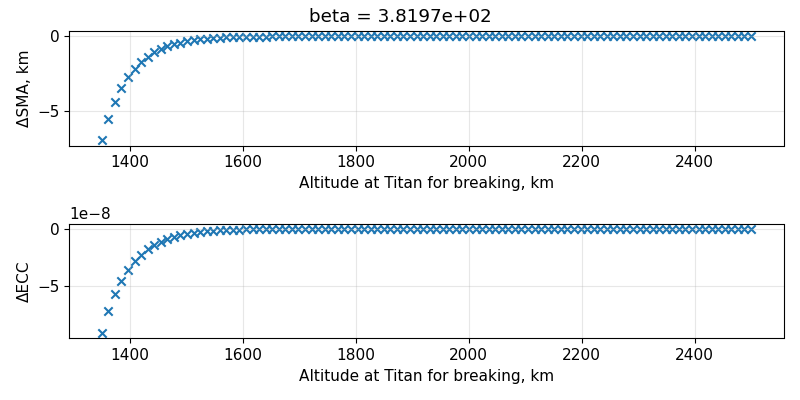

In [187]:
plt.rcParams["font.size"] = 11

fig, axs = plt.subplots(2,1,figsize=(8,4))

im0 = axs[0].scatter((rp_test-R_TITAN)/1e3, delts_single[:,0]/1e3, marker="x")
axs[0].set(xlabel="Altitude at Titan for breaking, km", ylabel=f"ΔSMA, km")
axs[0].grid(True, alpha=0.3)

im1 = axs[1].scatter((rp_test-R_TITAN)/1e3, delts_single[:,1], marker="x")
axs[1].set(xlabel="Altitude at Titan for breaking, km", ylabel=f"ΔECC")
axs[1].grid(True, alpha=0.3)

plt.suptitle(f'beta = {beta:1.4e}')
plt.tight_layout(rect=[0, 0.0, 1, 1.05])
plt.show()